In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/GSET25")
!pwd

/content/drive/MyDrive/GSET25


In [ ]:
!pip install medmnist
!pip install monai-generative
!pip install lpips

In [ ]:
import numpy as np
from medmnist import PneumoniaMNIST, ChestMNIST
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor



class MyMedMNIST(ChestMNIST):
    def __getitem__(self, item):
        img, _ = super().__getitem__(item)
        return img

if __name__ == '__main__':
    image_size = 64
    train_data = MyMedMNIST(split="train", download=True, size=image_size,root="/content/drive/MyDrive/GSET25", transform=ToTensor())
    print(train_data)
    indices = list(range(4000))
    train_data = Subset(train_data, indices)
    print(len(train_data))

    val_data = MyMedMNIST(split="val", download=True, size=image_size,root="/content/drive/MyDrive/GSET25" ,transform=ToTensor())
    print(val_data)
    val_data = Subset(val_data, list(range(500)))
    print(len(val_data))

    test_data = MyMedMNIST(split="test", download=True, size=image_size,root="/content/drive/MyDrive/GSET25", transform=ToTensor())
    print(test_data)
    test_data = Subset(test_data, list(range(500)))
    print(len(test_data))

    train_loader = DataLoader(
        dataset=train_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )
    val_loader = DataLoader(
        dataset=val_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )

100%|██████████| 402M/402M [00:23<00:00, 17.1MB/s]


Dataset MyMedMNIST of size 64 (chestmnist_64)
    Number of datapoints: 78468
    Root location: /content/drive/MyDrive/GSET25
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
4000
Using downloaded and verified file: /content/drive/MyDrive/GS

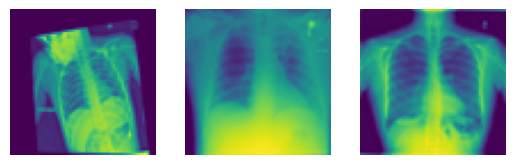

In [ ]:
check_data = next(iter((train_loader)))
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data[image_n, 0, :, :])
    ax[image_n].axis("off")

In [ ]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
from scipy import linalg
import pathlib
from INCEPTION import InceptionV3

from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import DiffusionModelUNet, PatchDiscriminator, AutoencoderKL
from generative.networks.schedulers import DDPMScheduler
# from generative_custom.networks.nets import AutoencoderKL

In [ ]:
set_determinism(42)

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

In [ ]:
check_data = next(iter((train_loader)))
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data[image_n, 0, :, :])
    ax[image_n].axis("off")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import gc
# Xóa biến không cần thiết
gc.collect()
torch.cuda.empty_cache()

In [ ]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
# autoencoderkl = AutoencoderKL(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=1,
#     num_channels=(128, 128, 256),
#     latent_channels=3,
#     num_res_blocks=2,
#     attention_levels=(False, True, True),
#     with_encoder_nonlocal_attn=False,
#     with_decoder_nonlocal_attn=False,
# )
autoencoderkl = autoencoderkl.to(device)

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted

In [ ]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=1, out_channels=1)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [ ]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

<ipython-input-56-a3c26ff30d0e>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_g = torch.cuda.amp.GradScaler()
<ipython-input-56-a3c26ff30d0e>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_d = torch.cuda.amp.GradScaler()


In [ ]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

start_time = time.time()

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch.to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()
del discriminator
del perceptual_loss
torch.cuda.empty_cache()

elapsed_time = time.time() - start_time
print(f"Total training time: {elapsed_time:.2f} seconds")

Epoch 0:   0%|                                                                         | 0/32 [00:00<?, ?it/s]<ipython-input-57-af321faf7af7>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 9: 100%|███████████████████| 32/32 [00:23<00:00,  1.37it/s, recons_loss=0.0371, gen_loss=0, disc_loss=0]
<ipython-input-57-af321faf7af7>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


epoch 10 val loss: 0.0352


Epoch 11:   0%|                                                                        | 0/32 [00:00<?, ?it/s]<ipython-input-57-af321faf7af7>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 19: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0305, gen_loss=0.258, disc_loss=0.253]


epoch 20 val loss: 0.0293


Epoch 29: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0273, gen_loss=0.318, disc_loss=0.247]


epoch 30 val loss: 0.0277


Epoch 39: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0266, gen_loss=0.318, disc_loss=0.226]


epoch 40 val loss: 0.0266


Epoch 49: 100%|████████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0236, gen_loss=0.3, disc_loss=0.225]


epoch 50 val loss: 0.0235


Epoch 59: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0226, gen_loss=0.336, disc_loss=0.235]


epoch 60 val loss: 0.0232


Epoch 69: 100%|████████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0211, gen_loss=0.3, disc_loss=0.239]


epoch 70 val loss: 0.0209


Epoch 79: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0194, gen_loss=0.285, disc_loss=0.238]


epoch 80 val loss: 0.0194


Epoch 89: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0187, gen_loss=0.295, disc_loss=0.242]


epoch 90 val loss: 0.0181


Epoch 99: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, recons_loss=0.0178, gen_loss=0.291, disc_loss=0.234]


epoch 100 val loss: 0.0200
Total training time: 2417.21 seconds


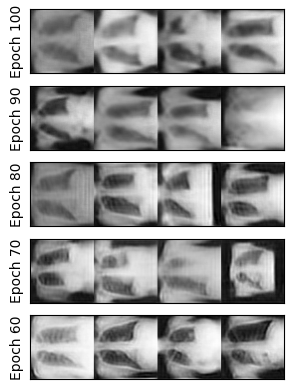

In [ ]:
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

In [ ]:
# unet = DiffusionModelUNet(
#     spatial_dims=2,
#     in_channels=3,
#     out_channels=3,
#     num_res_blocks=2,
#     num_channels=(128, 256, 512),
#     attention_levels=(True, True, True),
#     num_head_channels=(128, 256, 512),
# )
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

In [ ]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data.to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.7737697958946228


<ipython-input-60-b5736922d33f>:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


In [ ]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

<ipython-input-62-f7415d790f2d>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                 | 0/32 [00:00<?, ?it/s]<ipython-input-62-f7415d790f2d>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 39: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s, loss=0.0989]
<ipython-input-62-f7415d790f2d>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
<ipython-input-62-f7415d790f2d>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 39 val loss: 0.1006


100%|██████████| 1000/1000 [00:22<00:00, 44.29it/s]


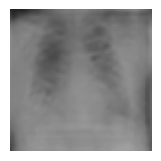

Epoch 40:   0%|                                | 0/32 [00:00<?, ?it/s]<ipython-input-62-f7415d790f2d>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 49: 100%|███████████| 32/32 [00:14<00:00,  2.18it/s, loss=0.102]

Total inference time: 763.73 seconds


In [ ]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 50
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()
start_time = time.time()
for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch.to(device)

                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")
        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )
        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()
elapsed_time = time.time() - start_time
print(f"Total inference time: {elapsed_time:.2f} seconds")

In [ ]:
list_inter = []
start_time = time.time()
for i in range(10):
  unet.eval()
  scheduler.set_timesteps(num_inference_steps=1000)
  noise = torch.randn((1, 3, 16, 16))
  noise = noise.to(device)
  with torch.no_grad():
      image, intermediates = inferer.sample(
          input_noise=noise,
          diffusion_model=unet,
          scheduler=scheduler,
          save_intermediates=True,
          intermediate_steps=100,
          autoencoder_model=autoencoderkl,
      )
  list_inter.append(intermediates)

elapsed_time = time.time() - start_time
print(f"Total training time: {elapsed_time:.2f} seconds")

100%|██████████| 1000/1000 [00:17<00:00, 57.13it/s]

Total training time: 178.73 seconds


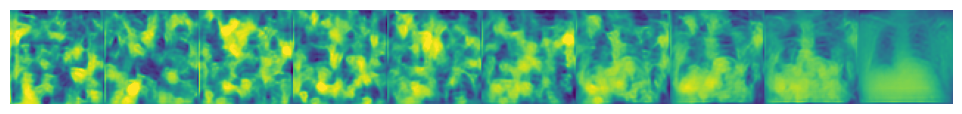

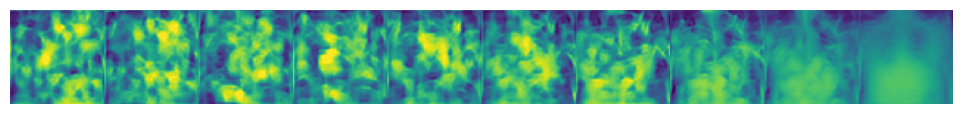

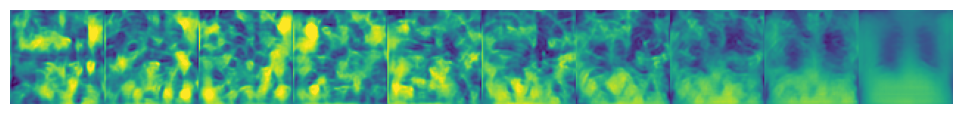

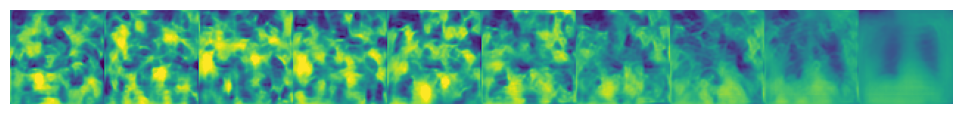

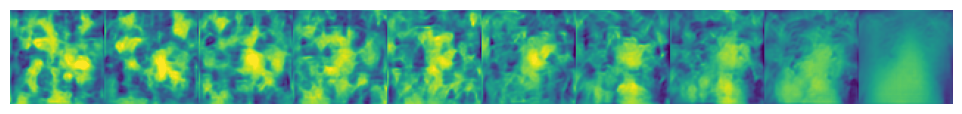

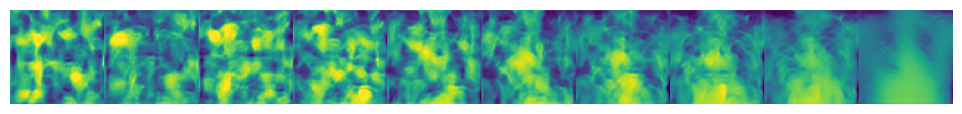

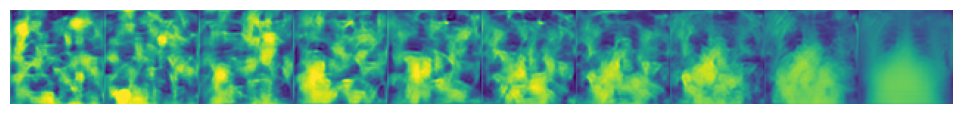

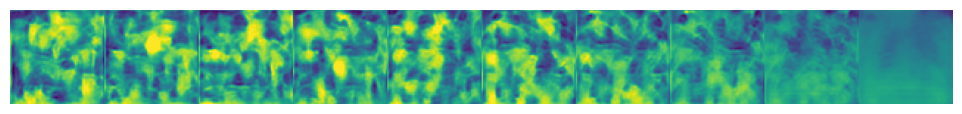

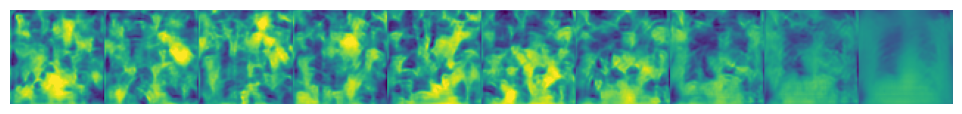

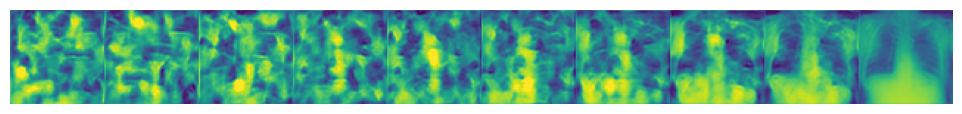

In [ ]:
for intermediates in list_inter:
  decoded_images = []
  for image in intermediates:
      with torch.no_grad():
          decoded_images.append(image)
  plt.figure(figsize=(10, 12))
  chain = torch.cat(decoded_images, dim=-1)
  plt.style.use("default")
  plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1)
  plt.tight_layout()
  plt.axis("off")

In [ ]:
for batch in val_loader:
    print(type(batch))
    print(len(batch))
    print(batch)
    break

<class 'torch.Tensor'>
128
tensor([[[[0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0275],
          [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0275],
          [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0039, 0.0275],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.5804, 0.5373, 0.6471],
          [0.0078, 0.0078, 0.0078,  ..., 0.6392, 0.6078, 0.7020],
          [0.0078, 0.0078, 0.0078,  ..., 0.7333, 0.7020, 0.7765]]],


        [[[0.3843, 0.2039, 0.1098,  ..., 0.1961, 0.2039, 0.2157],
          [0.3686, 0.1961, 0.1059,  ..., 0.0941, 0.0980, 0.1020],
          [0.3569, 0.1882, 0.1020,  ..., 0.0902, 0.0902, 0.0941],
          ...,
          [0.1059, 0.0824, 0.0784,  ..., 0.0863, 0.1176, 0.2118],
          [0.1059, 0.0824, 0.0784,  ..., 0.0863, 0.1216, 0.2157],
          [0.1137, 0.0941, 0.0980,  ..., 0.0863, 0.1216, 0.2196]]],


        [[[0.6235, 0.5020, 0.4627,  ..., 0.6275, 0.6510, 0.6902],
          [0.0824, 0.0275, 0.0235,  ..., 0.1647, 0.1765, 0.2196],
          [

In [ ]:
from PIL import Image

os.makedirs("src_chest", exist_ok=True)
selected_images = []
for i, images in enumerate(val_loader):
    if len(selected_images) >= 10:
        break
    for j in range(images.size(0)):
        selected_images.append(images[j])
        if len(selected_images) == 10:
            break
for i, image in enumerate(selected_images):
    image = image.squeeze(0)
    image = image.cpu().numpy()
    image = (image * 255).astype(np.uint8)
    pil_image = Image.fromarray(image, mode="L")
    pil_image.save(f"src_chest/src_chest_pic_{i}.jpg")

In [ ]:
os.makedirs("gen_chest_moom", exist_ok=True)
i = 0

for intermediates in list_inter:
    image = intermediates[-1]
    image = image.squeeze(0).squeeze(0)
    image = image.cpu().numpy()
    image = (image * 255).astype(np.uint8)
    pil_image = Image.fromarray(image, mode="L")
    pil_image.save(f"gen_chest_moom/gen_chest_pic_{i}.jpg")
    i += 1

In [ ]:
torch.save(unet.state_dict(), '/content/drive/MyDrive/GSET25/chest_unet_model.pth')
torch.save(scheduler.state_dict(), '/content/drive/MyDrive/GSET25/chest_scheduler_model.pth')
torch.save(autoencoderkl.state_dict(), '/content/drive/MyDrive/GSET25/chest_autoencoder_model.pth')

In [ ]:
IMAGE_EXTENSIONS = {'jpg'}
import numpy as np
from tqdm import tqdm
from scipy import linalg
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
from INCEPTION import InceptionV3
import pathlib

class ImagePathDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        # Only include ToTensor if not already in the provided transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor()  # Default: Convert PIL image to tensor
            ])
        else:
            self.transform = transform  # Use provided transform as-is

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')  # Open the image as PIL
        img = self.transform(img)  # Apply transformations
        return img

In [ ]:
def get_activations(files, model, batch_size, dims, device='cpu'):

    model.eval()

    if batch_size > len(files):
        batch_size = len(files)

    dataset = ImagePathDataset(files, transform=transforms.ToTensor())
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    pred_arr = np.empty((len(files), dims))
    start_idx = 0

    for batch in tqdm(data_loader):
        batch = batch.to(device)

        with torch.inference_mode():
            pred = model(batch)[0]

        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()
        pred_arr[start_idx:start_idx+pred.shape[0]] = pred
        start_idx = start_idx + pred.shape[0]

    return pred_arr

In [ ]:
def calculate_frechet_distance(mu1, mu2, sigma1, sigma2, eps=1e-6):

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces sigular product; adding %s to diagonal cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [ ]:
def calculate_activation_statistics(files, model, batch_size, dims, device='cpu'):

    act = get_activations(files, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)

    return mu, sigma

def compute_statistics_of_path(path, model, batch_size, dims, device='cpu'):

    path = pathlib.Path(path)
    files = sorted([file for ext in IMAGE_EXTENSIONS for file in path.glob('*.{}'.format(ext))])
    mu, sigma = calculate_activation_statistics(files, model, batch_size, dims, device)

    return mu, sigma

def calculate_fid_given_paths(path1, path2, batch_size, dims, device='cpu'):

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    print(block_idx)
    model = InceptionV3([block_idx]).to(device)

    mu1, sigma1 = compute_statistics_of_path(path1, model, batch_size, dims, device)
    mu2, sigma2 = compute_statistics_of_path(path2, model, batch_size, dims, device)

    fid_value = calculate_frechet_distance(mu1, mu2, sigma1, sigma2)
    return print('FID distance:', round(fid_value, 3))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 50
dims = 768

src_path = os.getcwd() + '/src_chest'
gen_path = os.getcwd() + '/gen_chest_moom'

print('Total images in src_path:', len(next(os.walk('src_chest'))[2]))
print('Total images in gen_path:', len(next(os.walk('gen_chest_moom'))[2]))

calculate_fid_given_paths(path1=src_path, path2=gen_path, batch_size=batch_size, dims=dims, device=device)

Total images in src_path: 10
Total images in gen_path: 10
2


100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


FID distance: 1.334
